___
## Ciência dos Dados - PROJETO 3 - INSPER

___
#### Freddy Dratwa

#### Victor Vazquez

#### Michel Haggiag

#### Allan Singer

#### Ricardo Ferraro

___

# Estudo do preço do carro

___

## A. INTRODUÇÃO

O objetivo deste projeto é chegar ao melhor modelo possível que seja capaz de prever o preço de um carro usado nos EUA a partir das características presentes no dataset:
    - Preço;
    - Ano;
    - Quilometragem;
    - Cidade;
    - Estado;
    - Marca;
    - Modelo;
    - Número de Chassis.

A base de dados possui 1.2 milhão de carros com data de produção entre os anos 1997 a 2018 de 58 marcas diferentes, sendo estes 2914 modelos distintos com o preço mÍnimo de US1.500,00 e máximo de US462.000,00 , com a mínima quilometragem 8 Km e a máxima 2.286.260,8 Km.<br>

Como uma primeira previsão, imagina-se que algumas das características do dataset influenciam mais no preço do carro do que outras. Por exemplo, é de se esperar que um carro comprado há mais tempo tenha seu preço menor atualmente. Ou seja, a variavel "Ano", que representa o ano em que o carro foi fabricado, deve influenciar muito no preço do veículo, bem como a quilometragem, onde um carro que foi comprado mas usado pouco deve permanecer mais barato do que um usado muitas vezes.<br>



___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

### BASE DE DADOS

**Limpando e tratando dataset**

Nas células abaixo, o dataset é limpo e reorganiazdo. Para se fazer isso, a coluna "Chassi" é removoida, pois esta é uma característica individual para cada veículo e não influencia no preço final do mesmo, acompanhada da variável "Estado", que é retirada pois a localização onde o carro é usado não altera seu preço após um certo período de tempo. Alem disso, duas colunas vazias foram reitradas. Então, a variável milhagem foi transformada em quilometragem, multplicando seu valor por 1.6. Por último, a variavel ano foi transformada em idade, ou seja, a diferença do ano atual (2019) para o ano em que o carro foi vendido. 

In [3]:
dataset = pd.read_csv("Dataframe.csv")

In [4]:
if "Vin" in dataset:
    dataset = dataset.drop(columns=["Vin", "Unnamed: 9", "Unnamed: 10", "Unnamed: 0"])
    dataset["Mileage"] = dataset["Mileage"].apply(lambda x: x*1.6)

    dataset.columns = ["ID","PRECO","ANO","KM","CIDADE","ESTADO","MARCA","MODELO"]
    dataset["IDADE"] = dataset["ANO"].apply(lambda x: 2019-x)

    dataset.ID = dataset.ID.astype("float")
    dataset.PRECO = dataset.PRECO.astype("float")
    dataset.ANO = dataset.ANO.astype("float")
    dataset.KM = dataset.KM.astype("float")
    dataset.IDADE = dataset.IDADE.astype("float")
    dataset.CIDADE = dataset.CIDADE.astype("category")
    dataset.ESTADO = dataset.ESTADO.astype("category")
    dataset.MARCA = dataset.MARCA.astype("category")
    dataset.MODELO = dataset.MODELO.astype("category")

    dataset["ESTADO"] = dataset["ESTADO"].apply(lambda x: x.upper())
    dataset["CIDADE"] = dataset["CIDADE"].apply(lambda x: x.upper())
    dataset["MARCA"] = dataset["MARCA"].apply(lambda x: x.upper())
    dataset = dataset[["ID","PRECO","ANO","IDADE","KM","CIDADE","ESTADO","MARCA","MODELO"]]

In [5]:
dataset.head()

,ID,PRECO,ANO,IDADE,KM,CIDADE,ESTADO,MARCA,MODELO
0,79293.0,18684.0,2015.0,4.0,19998.4,OWENSBORO,KY,DODGE,JourneySXT
1,190834.0,26318.0,2016.0,3.0,13563.2,CORPUS CHRISTI,TX,BMW,3
2,670383.0,25802.0,2014.0,5.0,105404.8,PORT LAVACA,TX,FORD,ExplorerLimited
3,586732.0,9899.0,2005.0,14.0,173619.2,LINDON,UT,DODGE,Dakota4WD
4,37609.0,30999.0,2016.0,3.0,13372.8,FOND DU LAC,WI,FORD,MustangFastback


## ANÁLISE DESCRITIVA

Nas celulas que seguem, ocorre a análise descritiva das variaveis, semelhante ao projeto 1. Em um primeiro momento, serão analisadas cada uma das variáveis. 

**Características da variável Preço**

In [6]:
dataset["PRECO"].describe()

count    100000.000000
mean      21032.639190
std       13079.287997
min        1500.000000
25%       12991.000000
50%       17995.000000
75%       26590.000000
max      429900.000000
Name: PRECO, dtype: float64

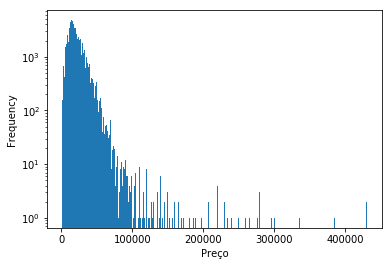

In [7]:
dataset["PRECO"].plot.hist(logy = True, bins = 500);
plt.xlabel("Preço");

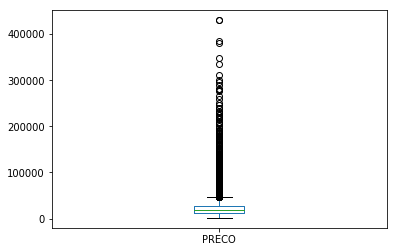

In [8]:
dataset["PRECO"].plot.box()
plt.show()

**Características da variável Idade**

In [9]:
dataset["IDADE"].describe()

count    100000.00000
mean          5.68960
std           3.42571
min           1.00000
25%           3.00000
50%           5.00000
75%           7.00000
max          22.00000
Name: IDADE, dtype: float64

In [10]:
dataset["IDADE"].value_counts().head(5)

4.0    18254
5.0    18123
3.0    15668
2.0    11483
6.0     8853
Name: IDADE, dtype: int64

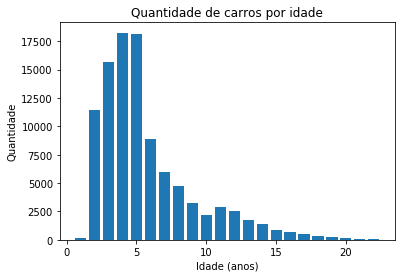

In [11]:
quantidade_por_idade = []
for i in range(22):
    quantidade_por_idade.append(len(dataset["IDADE"].loc[dataset["IDADE"] == i+1]))


plt.bar(np.arange(1,23,1), quantidade_por_idade)
plt.title("Quantidade de carros por idade")
plt.xlabel("Idade (anos)")
plt.ylabel("Quantidade")
plt.show()

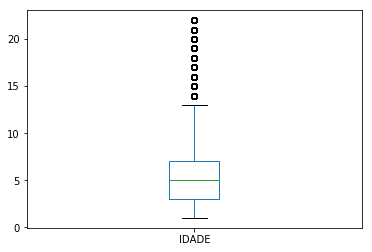

In [12]:
dataset["IDADE"].plot.box()
plt.show()

Análise:

A variável analisada idade, é a diferença entre o ano de hoje (2019), para o ano em que o carro foi fabricado. Após as plotagens do histograma e do boxplot, nota-se a grande maioria dos carros foi tem até 5 anos de idade, ou seja, a maioria deles são carros "jovens". Esta informação é confirmada pelo boxplot. Entretanto, existem alguns outliers, que ficam evidenciados em ambos os gráficos. Eles mostram que varios carros têm mais do que 5 anos de idade.

**Características da variável Km**

In [13]:
dataset["KM"].describe()

count    1.000000e+05
mean     8.462736e+04
std      6.670870e+04
min      8.000000e+00
25%      3.883040e+04
50%      6.530400e+04
75%      1.160008e+05
max      2.062016e+06
Name: KM, dtype: float64

(-10000, 400000)

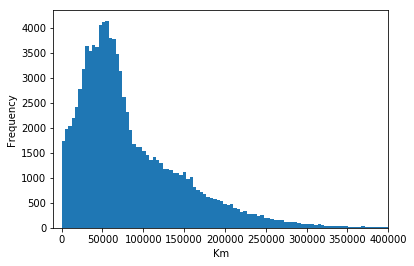

In [14]:
dataset["KM"].plot.hist(bins=500);
plt.xlabel("Km");
plt.xlim(-10000,400000)

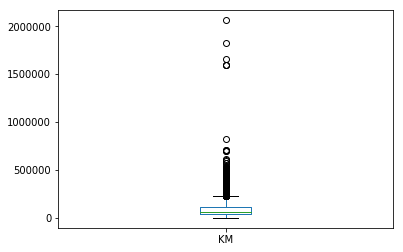

In [15]:
dataset["KM"].plot.box()
plt.show()

Análise:

A próxima variavel analisada é a quilometragem, ou seja, quantos quilometros os carros ja rodaram. Pelo fato de a maioria dos carros terem sido fabricados há menos de 10 anos, imagina-se que em sua maioria, os carros não tenham quilometragem alta. Esta hipótese é confirmada pelos gráficos. Com a plotagem do histograma e do boxplot, percebe-se que a maioria dos carros tem 50000 km rodados, sendo que existem alguns com mais e outros com menos. Este já é um número considerável mas, como pode se ver no boxplot, existem carros com mais de 3 milhões de km rodados. Assim, 50000 parece um numero pequeno. Tambem fica claro pelo boxplot que existe uma quantidade consideravel de outliers. Mesmo assim, a concentração maior se encontra nos 50000 km. 

**Característica da variável Marca**

In [16]:
dataset["MARCA"].describe()

count     100000
unique        58
top         FORD
freq       15317
Name: MARCA, dtype: object

In [17]:
dataset["MARCA"].value_counts().head(10)

FORD             15317
CHEVROLET        14362
HONDA             7289
NISSAN            6940
JEEP              5726
HYUNDAI           5305
DODGE             4871
KIA               4091
GMC               4071
MERCEDES-BENZ     3572
Name: MARCA, dtype: int64

Análise:

Como é de se imaginar, o preço de um veículo é muito afetado pela sua marca. Por exemplo, uma Ferrari será muito mais cara do que a grande maioria dos carros da ford, por exemplo. Além disso, nota-se a partir da análise dos value counts feitos que existem muito mais carros de marcas popuares, justamente por que são mais baratos. 

**Característica da variável Modelo**

In [18]:
dataset["MODELO"].describe()

count        100000
unique         2109
top       Silverado
freq           3431
Name: MODELO, dtype: object

In [19]:
dataset["MODELO"].value_counts().head(10)

Silverado    3431
Grand        2388
Altima2.5    1532
Sierra       1503
Accord       1434
F-1504WD     1268
Civic        1164
Wrangler     1142
3            1045
Santa         944
Name: MODELO, dtype: int64

Análise:

A variável analisada é o modelo do carro. O modelo usará esta para prever o preço do carro usando a seguinte lógica: se um modelo encontra-se entre os mais comprados, provavelmente significa que é um dos mais baratos, por que, geralmente os carros mais vendidos são aqueles mais baratos.

### ANÁLISE DESCRITIVA

(-10000, 500000)

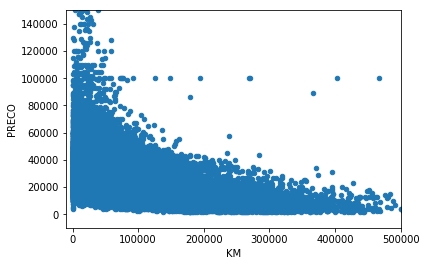

In [20]:
dataset.plot.scatter(y = "PRECO", x = "KM");
plt.ylim(-10000,150000)
plt.xlim(-10000,500000)

Analisando o gráfico Preço x Km, nota-se que o preço do veículo vai caindo conforme a quilometragem do mesmo aumenta, na maioria dos casos.

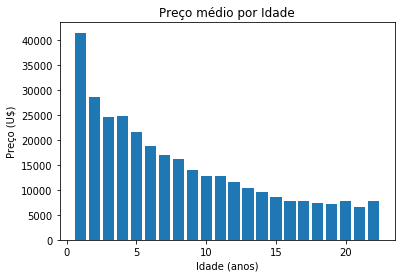

In [21]:
price_mean_by_year = []
for i in range(22):
    price_mean_by_year.append(dataset[dataset.IDADE == 1+i].PRECO.mean())
plt.bar(np.arange(1,23,1), price_mean_by_year)
plt.title("Preço médio por Idade")
plt.xlabel("Idade (anos)")
plt.ylabel("Preço (U$)")
plt.show()

Analisando o gráfico, é possível verificar que o preço dos carros diminui conforme o mesmo envelhece. Também é possível verificar que há queda mais efetiva no preço nos primeiros anos. 

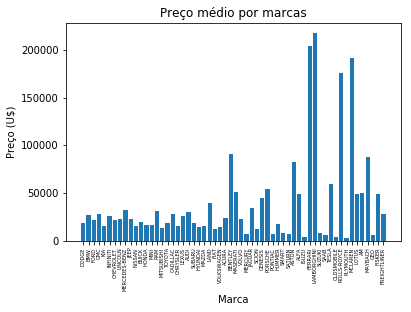

In [22]:
marcas = dataset["MARCA"].unique()

price_mean_by_marca = []
for i in marcas:
    price_mean_by_marca.append(dataset[dataset.MARCA == i].PRECO.mean())

plt.bar(marcas, price_mean_by_marca)
plt.xticks(rotation = 90, fontsize = 5)
plt.title("Preço médio por marcas")
plt.xlabel("Marca")
plt.ylabel("Preço (U$)")
plt.show()


O gráfico acima permite afirmar o que foi previsto na análise das informações do modelo do veículo. Como imaginado, o preço dos veículos aumenta conforme a marca. Por exemplo, as que têm os veículos mais caros são Rolss-Royce, Ferrari, Lambhorghini e Mercedes, justamente as marcas que esperava-se que teriam carros mais caros, por serem mais "famosas" por terem carros de alto nivel.

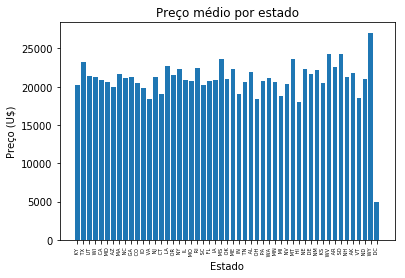

In [23]:
estados = dataset["ESTADO"].unique()

price_mean_by_estado = []
for i in estados:
    price_mean_by_estado.append(dataset[dataset.ESTADO == i].PRECO.mean())

plt.bar(estados, price_mean_by_estado)
plt.xticks(rotation = 90, fontsize = 5)
plt.title("Preço médio por estado")
plt.xlabel("Estado")
plt.ylabel("Preço (U$)")
plt.show()

___
## C. MODELOS DE PREDIÇÃO

o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

**Separando a base de dados em treinamento e teste aleatoriamente**

In [24]:
train, test = train_test_split(dataset, test_size=0.25, train_size=0.75)
Y_train = train["PRECO"]
Y_test = test["PRECO"]

In [25]:
y_train = train["PRECO"].mean()
y_test = test["PRECO"].mean() # contem o preco previsto de um novo carro da base teste pelo moedelo de medias

In [26]:
rms_train = []
rms_test = []
num_train = []
dem_train = []
num_test = []
dem_test = []

trainpreco = train["PRECO"].tolist()
testpreco = test["PRECO"].tolist()

for a in trainpreco:
    rms_train.append((a-y_train)**2)
    num_train.append((a-y_train)**2)
    dem_train.append((a-y_train)**2)
for e in testpreco:
    rms_test.append((e-y_train)**2)
    num_test.append((e-y_train)**2)
    dem_test.append((e-y_test)**2)

RMS_train_M = np.sqrt(np.mean(rms_train))
RMS_test_M = np.sqrt(np.mean(rms_test))
R_train_M = 1-(sum(num_train)/sum(dem_train))
R_test_M = 1-(sum(num_test)/sum(dem_test))

In [27]:
R_train_M,RMS_train_M

(0.0, 13116.387874787326)

In [28]:
R_test_M, RMS_test_M

(-1.212754264723337e-05, 12967.107326608257)

In [29]:
R_perc_M = 0
RMS_perc_M = ((RMS_test_M-RMS_train_M)/RMS_train_M)*100

o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

In [30]:
X_train = train
X_test = test

X_train = X_train.drop(columns = ["ID", "PRECO","ANO", "CIDADE", "ESTADO", "MARCA", "MODELO"])
X_test = X_test.drop(columns = ["ID", "PRECO","ANO", "CIDADE", "ESTADO", "MARCA", "MODELO"])

In [31]:
lista_erros = []
for k in range(1, 16):
    clf = KNeighborsRegressor(k)
    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    lista_erros.append(mean_squared_error(Y_test,Y_pred))

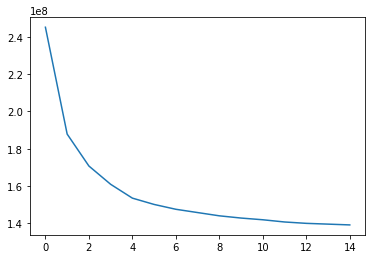

In [32]:
plt.plot(lista_erros);

In [33]:
clf = KNeighborsRegressor(8)
clf.fit(X_train,Y_train)
Y_pred_train = clf.predict(X_train)
Y_pred_test = clf.predict(X_test)

In [34]:
rms_train_K = []
rms_test_K = []
num_train_K = []
dem_train_K = []
num_test_K = []
dem_test_K = []


for a in range(len(trainpreco)):
    rms_train_K.append((trainpreco[a]-Y_pred_train[a])**2)
    num_train_K.append((trainpreco[a]-Y_pred_train[a])**2)
    dem_train_K.append((trainpreco[a]-y_train)**2)
for e in range(len(testpreco)):
    rms_test_K.append((testpreco[e]-Y_pred_test[e])**2)
    num_test_K.append((testpreco[e]-Y_pred_test[e])**2)
    dem_test_K.append((testpreco[e]-y_test)**2)

RMS_train_K = np.sqrt(np.mean(rms_train_K))
RMS_test_K = np.sqrt(np.mean(rms_test_K))
R_train_K = 1-(sum(num_train_K)/sum(dem_train_K))
R_test_K = 1-(sum(num_test_K)/sum(dem_test_K))

In [35]:
R_train_K, RMS_train_K

(0.3151200511718788, 10854.791273662646)

In [36]:
R_test_K, RMS_test_K

(0.133039634188449, 12073.692027788196)

In [37]:
R_perc_K = ((R_test_K-R_train_K)/R_train_K)*100
RMS_perc_K = ((RMS_test_K-RMS_train_K)/RMS_train_K)*100

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

In [38]:
X_train = train
X_test = test

X_train = X_train.drop(columns = ["ID", "PRECO","ANO", "CIDADE", "ESTADO", "MARCA", "MODELO"])

X_test = X_test.drop(columns = ["ID", "PRECO","ANO", "CIDADE", "ESTADO", "MARCA", "MODELO"])

In [39]:
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, Y_train);

Y_pred_train = regressor.predict(X_train)

Y_pred_test = regressor.predict(X_test)

In [40]:
rms_train_A = []
rms_test_A = []
num_train_A = []
dem_train_A = []
num_test_A = []
dem_test_A = []

trainpreco = train["PRECO"].tolist()
testpreco = test["PRECO"].tolist()

for a in range(len(trainpreco)):
    rms_train_A.append((trainpreco[a]-Y_pred_train[a])**2)
    num_train_A.append((trainpreco[a]-Y_pred_train[a])**2)
    dem_train_A.append((trainpreco[a]-y_train)**2)
for e in range(len(testpreco)):
    rms_test_A.append((testpreco[e]-Y_pred_test[e])**2)
    num_test_A.append((testpreco[e]-Y_pred_test[e])**2)
    dem_test_A.append((testpreco[e]-y_test)**2)

RMS_train_A = np.sqrt(np.mean(rms_train_A))
RMS_test_A = np.sqrt(np.mean(rms_test_A))
R_train_A = 1-(sum(num_train_A)/sum(dem_train_A))
R_test_A = 1-(sum(num_test_A)/sum(dem_test_A))


R_perc_A = ((R_test_A-R_train_A)/R_train_A)*100
RMS_perc_A = ((RMS_test_A-RMS_train_A)/RMS_train_A)*100

In [41]:
R_train_A, RMS_train_A

(0.9292798581129723, 3488.0749857417827)

In [42]:
R_test_A, RMS_test_A

(-0.4263570994459829, 15486.547397071141)

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

In [43]:
def dummify(data, column_name):
    return pd.get_dummies(data[column_name],drop_first = False, prefix = column_name)

def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y, X_cp)
    results = model.fit()
    ypred = results.predict(X_cp)
    return results, ypred

In [44]:
traindummy = pd.concat([dummify(dataset, "ESTADO").dropna(), dummify(dataset, "MODELO").dropna(), dummify(dataset, "MARCA").dropna()], axis=1)
dt = dataset.drop(columns = ["ID", "ANO", "CIDADE", "ESTADO", "MARCA", "MODELO"])
final = pd.concat([dt, traindummy], axis = 1)

In [45]:
train, test = train_test_split(final, test_size = 0.25, train_size = 0.75)

In [46]:
df = train

x = df[np.delete(df.columns.values, 0)]
y = df[["PRECO"]]

results = regress(x,y)

dataresultados = pd.read_html(results[0].summary().tables[1].as_html(), header=0, index_col=0)[0]

In [48]:
results[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRECO   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     216.6
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        17:36:30   Log-Likelihood:            -7.4376e+05
No. Observations:               75000   AIC:                         1.492e+06
Df Residuals:                   72940   BIC:                         1.511e+06
Df Model:                        2059                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         5.037e+04    269.455    186.951      0.000    4.98e+04    5.09e+04
IDADE                        -1464.9967     10.879   -134.659      0.000   -1486.320   -1443.673
KM                              -0.0417      0.000    -89.733      0.000      -0.043      -0.041
ESTADO_ AK                    1299.5631    463.128      2.806      0.005     391.833    2207.293
ESTADO_ AL                    1152.1025    176.797      6.517      0.000     805.582    1498.623
ESTADO_ AR                    1415.6357    228.153      6.205      0.000     968.457    1862.814
ESTADO_ AZ                     474.8808    149.146      3.184      0.001     182.556     767.206
ESTADO_ CA                     617.5384    118.876      5.195      0.000     384.542     850.535
ESTADO_ CO                    1179.6690    151.906      7.766      0.000     881.933    1477.405
ESTADO_ CT                     196.2115    198.017      0.991      0.322    -191.902     584.325
ESTADO_ DC                    6131.8964   4895.696      1.253      0.210   -3463.650    1.57e+04
ESTADO_ DE                     704.0682    340.599      2.067      0.039      36.495    1371.641
ESTADO_ FL                    -153.1445    119.403     -1.283      0.200    -387.174      80.885
ESTADO_ GA                     477.2930    132.648      3.598      0.000     217.303     737.283
ESTADO_ HI                    1347.1073    370.194      3.639      0.000     621.529    2072.686
ESTADO_ IA                    1538.1570    251.771      6.109      0.000    1044.686    2031.627
ESTADO_ ID                    1080.9180    291.954      3.702      0.000     508.689    1653.147
ESTADO_ IL                     688.1035    132.919      5.177      0.000     427.582     948.625
ESTADO_ IN                     329.3522    163.930      2.009      0.045       8.050     650.655
ESTADO_ KS                     654.4563    211.049      3.101      0.002     240.802    1068.111
ESTADO_ KY                      71.9629    169.739      0.424      0.672    -260.725     404.651
ESTADO_ LA                     607.0651    212.091      2.862      0.004     191.367    1022.763
ESTADO_ MA                     574.9907    161.280      3.565      0.000     258.882     891.099
ESTADO_ MD                     331.8466    161.742      2.052      0.040      14.832     648.861
ESTADO_ ME                     868.9957    408.943      2.125      0.034      67.470    1670.522
ESTADO_ MI                     -56.7422    186.189     -0.305      0.761    -421.671     308.187
ESTADO_ MN                    1046.1594    186.881      5.598      0.000     679.873    1412.446
ESTADO_ MO                    1026.5062    164.154      6.253      0.000     704.764    1348.248
ESTADO_ MS                    1340.5685    233.404      5.744      0.000    

In [49]:
print(len(dataresultados), len(df))

2221 75000


Pelo fato de a base de dados deste modelo possuir mais 2000 colunas e 100 mil linhas, o método mais correto de aplicação de regressão se tornou praticamente inviável uma vez que seria necessário pelo menos 17h para o código rodar. Assim, o código utilizado para se obter a regressão faz o processo de excluir as variáveis com valor-p maior que alpha e executar a função regress por apenas cinco vezes. O correto seria eliminar a variável com valor-p maior que alpha e executar a função regress e repetir o processo excluindo uma por uma as variáveis que não são uteis para o modelo.

In [50]:
for i in range(5):
    maiores = []
    for i in dataresultados.loc[(dataresultados["P>|t|"] > 0.10)].index.tolist():
        maiores.append(i)

    df = df.drop(columns = maiores)
    x = df[np.delete(df.columns.values, 0)]
    y = df[["PRECO"]]
    results = regress(x,y)
    dataresultados = pd.read_html(results[0].summary().tables[1].as_html(), header=0, index_col=0)[0]

In [51]:
print(len(dataresultados), len(df))

1405 75000


In [52]:
results[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRECO   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     328.5
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        17:39:43   Log-Likelihood:            -7.4450e+05
No. Observations:               75000   AIC:                         1.492e+06
Df Residuals:                   73659   BIC:                         1.504e+06
Df Model:                        1340                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         4.488e+04    174.751    256.820      0.000    4.45e+04    4.52e+04
IDADE                        -1452.6667     10.017   -145.017      0.000   -1472.300   -1433.033
KM                              -0.0418      0.000    -90.866      0.000      -0.043      -0.041
ESTADO_ AK                    1389.8733    460.684      3.017      0.003     486.935    2292.811
ESTADO_ AL                    1153.8012    152.988      7.542      0.000     853.946    1453.657
ESTADO_ AR                    1379.3787    212.041      6.505      0.000     963.780    1794.978
ESTADO_ AZ                     450.6029    117.818      3.825      0.000     219.680     681.526
ESTADO_ CA                     579.9008     73.741      7.864      0.000     435.369     724.432
ESTADO_ CO                    1185.7129    121.629      9.749      0.000     947.321    1424.105
ESTADO_ DE                     678.7054    333.841      2.033      0.042      24.379    1333.032
ESTADO_ GA                     453.1561     95.103      4.765      0.000     266.754     639.559
ESTADO_ HI                    1157.1999    362.195      3.195      0.001     447.298    1867.101
ESTADO_ IA                    1558.2109    238.768      6.526      0.000    1090.227    2026.195
ESTADO_ ID                    1085.4370    281.636      3.854      0.000     533.432    1637.442
ESTADO_ IL                     675.7244     95.505      7.075      0.000     488.535     862.914
ESTADO_ IN                     306.5319    136.938      2.238      0.025      38.135     574.929
ESTADO_ KS                     597.3111    193.195      3.092      0.002     218.650     975.972
ESTADO_ LA                     553.5855    193.957      2.854      0.004     173.430     933.741
ESTADO_ MA                     548.4670    133.576      4.106      0.000     286.658     810.276
ESTADO_ MD                     305.4070    134.136      2.277      0.023      42.500     568.314
ESTADO_ ME                     819.7515    407.479      2.012      0.044      21.094    1618.409
ESTADO_ MN                    1042.0923    164.836      6.322      0.000     719.015    1365.170
ESTADO_ MO                    1037.8854    137.300      7.559      0.000     768.778    1306.992
ESTADO_ MS                    1287.3893    218.208      5.900      0.000     859.702    1715.076
ESTADO_ MT                    2264.2077    384.279      5.892      0.000    1511.023    3017.393
ESTADO_ NC                     899.4261     97.180      9.255      0.000     708.955    1089.898
ESTADO_ NE                    1529.0447    248.649      6.149      0.000    1041.693    2016.396
ESTADO_ NH                     733.3357    235.460      3.114      0.002     271.835    1194.836
ESTADO_ NJ                     467.8284    112.506      4.158      0.000    

In [53]:
quanti = 0
for i in dataresultados["P>|t|"]:
    if i > 0.10:
        quanti+=1
print("Quantidade de colunas com P>|t| maiores que alpha de 10%: ", quanti)

Quantidade de colunas com P>|t| maiores que alpha de 10%:  8



### Análise da primeira versão da regressão linear "Train":


O coeficiente de determinação 𝑅-squared é uma medida que representa o quão bem o modelo é capaz de captar a variabilidade dos dados. Para esta medida, quanto mais próximo de 1, melhor a percepção de variabilidade do modelo. Com isso em mente, o valor inicial de 0.862 obtido a partir da regressão é satisfatório e indica que o modelo consegue de fato perceber a variabilidade nos dados. 

Existe no entanto, uma imprecisão na medida R-Squared que é agravada em modelos que contém um número elevado de variáveis não explicativas. Uma alternativa para esta medida é a R-Squared ajustada que compensa as variáveis não explicativas no modelo fornecendo um valor mais realista. O valor de R-squared ajustado fornecido pela regressão do modelo foi 0.859 o que continua sendo um valor alto confirmando a captação de variabilidade do modelo. 

A probabilidade estatística F, dada pelo valor Prob(F-statistic) é uma medida que indica a presença ou não de variáveis explicativas que contribuem significantemente para o modelo. A Prob(F-statistic) gerada pela regressão é igual a zero, o que confirma a presença de variáveis explicativas que contribuem para o modelo. 

Com o intuito de verificar a normalidade dos resíduos do modelo, é necessário analisar outros dois testes, sendo eles o Omnibus, dado por Prob(Omnibus) e Jarque-Bere (Prob(JB)). O resultado obtido pelo teste Omnibus foi muito próximo de zero, o que indica que os resíduos do modelo "Train" não são distribuidos normalmente, violando a suposição inicial e comprometendo a regressão como um todo. O teste Jarque-Bere, confirma o que havia sido observado pelo Omnibus, ou seja, não há normalidade entre os resíduos, dado o valor próximo de zero de Prob(JB).

### TEST

In [54]:
for i in test.columns.tolist():
    if i not in df.columns.tolist():
        test = test.drop(columns = [i])

In [55]:
test.head()

,PRECO,IDADE,KM,ESTADO_ AK,ESTADO_ AL,ESTADO_ AR,ESTADO_ AZ,ESTADO_ CA,ESTADO_ CO,ESTADO_ DE,...,MARCA_SAAB,MARCA_SATURN,MARCA_SCION,MARCA_SUBARU,MARCA_SUZUKI,MARCA_TESLA,MARCA_TOYOTA,MARCA_VOLKSWAGEN,MARCA_VOLVO,MARCA_SMART
52439,32495.0,2.0,29140.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21066,18888.0,4.0,47224.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58529,26500.0,6.0,118110.4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16558,20000.0,13.0,88484.8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68688,22975.0,8.0,205996.8,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
X_Test = sm.add_constant(test[np.delete(test.columns.values, 0)])
Y_pred_test = results[0].predict(X_Test).tolist()

In [57]:
rms_test_R = []
rms_train_R = []

testpreco = test["PRECO"].tolist()
trainpreco = train["PRECO"].tolist()

Y_pred_train = results[1].tolist()
Y_pred_test = results[0].predict(X_Test).tolist()


for a in range(len(trainpreco)):
    rms_train_R.append((trainpreco[a]-Y_pred_train[a])**2)

for e in range(len(testpreco)):
    rms_test_R.append((testpreco[e]-Y_pred_test[e])**2)


RMS_train_R = np.sqrt(np.mean(rms_train_R))
RMS_test_R = np.sqrt(np.mean(rms_test_R))
R_train_R = results[0].rsquared
R_test_R = r2_score(testpreco, Y_pred_test)

R_perc_R = ((R_test_R-R_train_R)/R_train_R)*100
RMS_perc_R = ((RMS_test_R-RMS_train_R)/RMS_train_R)*100

In [58]:
R_train_R, RMS_train_R

(0.8566349818390468, 4952.574707897617)

In [59]:
R_test_R, RMS_test_R

(0.8495002294062091, 5072.992470936008)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

In [60]:
predicoes = ["Media", "K-NN", "Regressão", "Árvore de Decisão"]
R_TRAIN = [R_train_M, R_train_K, R_train_R, R_train_A]
R_TEST = [R_test_M, R_test_K, R_test_R, R_test_A]
R_PERC = [R_perc_M, R_perc_K, R_perc_R, R_perc_A]
RMS_TRAIN = [RMS_train_M, RMS_train_K, RMS_train_R, RMS_train_A]
RMS_TEST = [RMS_test_M, RMS_test_K, RMS_test_R, RMS_test_A]
RMS_PERC = [RMS_perc_M, RMS_perc_K, RMS_perc_R, RMS_perc_A]
PREDI = pd.DataFrame(data = predicoes)
PREDI.columns = ["Modelo"]
PREDI["Rˆ2 Treinamento"] = R_TRAIN
PREDI["Rˆ2 Teste"] = R_TEST
PREDI["Rˆ2 %"] = R_PERC
PREDI["RMS Treinamento"] = RMS_TRAIN
PREDI["RMS Teste"] = RMS_TEST
PREDI["RMS %"] = RMS_PERC

In [61]:
PREDI

,Modelo,Rˆ2 Treinamento,Rˆ2 Teste,Rˆ2 %,RMS Treinamento,RMS Teste,RMS %
0,Media,0.000000,-0.000012,0.000000,13116.387875,12967.107327,-1.138122
1,K-NN,0.315120,0.133040,-57.781286,10854.791274,12073.692028,11.229150
2,Regressão,0.856635,0.849500,-0.832881,4952.574708,5072.992471,2.431417
3,Árvore de Decisão,0.929280,-0.426357,-145.880377,3488.074986,15486.547397,343.985507


___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS